# Assumptions:   Predicting Weight Loss and Activity Level (steps)
1. Exploration of the data shows that acitivity level (based on steps and activity colories) is significantly higher on weekends.   Therefore we decided to aggregate by week.   There are 33 weeks.
2. Based on adjusted BMR calculations, we believe this is a 25 year old male, 220 lbs, who has just started a workout program in April of 2018.    ** Need to support why we think this subject is a male, why we think he is 25 years old, and how we calculated an initial weight of 220 lbs**
3. need to document formulas used
4. not enough data to sufficently determine seasonality (partial year)
5. split based on calendar,  starting the second week of October,  which gives us 24 weeks in our train dataset, and 10 weeks in our test dataset
6. Baseline BMR are those days when Minutes_active = 0
7. Can calulate starting weight with approx 95% accuracy.  Can also calculate approximate height based on stride length.
8. Very confident in inital weight, as well as weight in first week of July.  Calculate average calorie intake based first week of November.
9. Have to assume that eating habits don't significantly change from April through December because we don't hace enough data.  We are ignoring Body Fat % because we don't have enough data and it is not necessary to predict weight or activity level (steps).  Have to assume an age (25).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import Holt
from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

In [2]:
df = pd.read_csv('Total_Fitbit_2.csv')

In [3]:
df.shape

(225, 11)

In [4]:
df['Date'] = pd.to_datetime(df.Date)

In [5]:
df.set_index('Date', drop=True, inplace= True)

In [6]:
df.replace(',','', regex=True, inplace=True)

In [7]:
cols = ['Calories_Burned', 'Steps', 'Distance', 'Floors', 'Minutes_Sedentary',
       'Minutes_Lightly_Active', 'Minutes_Fairly_Active',
       'Minutes_Very_Active', 'Activity_Calories', 'Calories_In']

df = df[cols].astype(float)

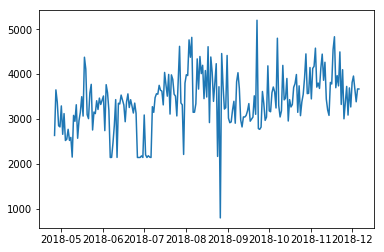

In [8]:
plt.plot(df.Calories_Burned)

In [9]:
df.shape

(225, 10)

In [10]:
aggregation = 'sum'
train = df[:'2018-10-07'].Steps.resample('W').agg(aggregation)
test = df['2018-10-07':].Steps.resample('W').agg(aggregation)
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 34
Training Observations: 24
Testing Observations: 10


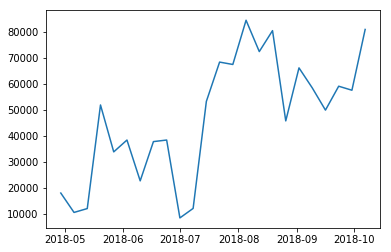

In [11]:
plt.plot(train)

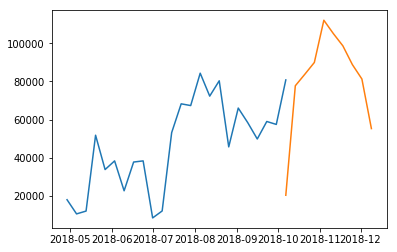

In [12]:
plt.plot(train)
plt.plot(test)
plt.show()

In [13]:
# sm.tsa.seasonal_decompose(train).plot()
# result = sm.tsa.stattools.adfuller(train)
# plt.show()

In [14]:
df['Distance_inches'] = df.Distance*63360

In [15]:
df['Gait_length'] = df.Distance_inches/df.Steps

In [16]:
df['BMR'] = df.Calories_Burned - df.Activity_Calories

In [17]:
# height = ((df.Gait_length.mean())/0.43)*2.54
h = 177.069
a = 25
b = 2145

In [18]:
h

177.069

In [19]:
df['weight_male_lb'] = (((((6.25*h)-(5*a)+5)-b)/-10)*2.20462)

In [20]:
df['weight_male_kg'] = (((6.25*h)-(5*a)+5)-b)/-10

In [21]:
df['weight_female_lb'] = ((((6.25*h)-(5*a)-161)-b)/-10)*2.20462

In [22]:
df['weight_female_kg'] = (((6.25*h)-(5*a)-161)-b)/-10

In [23]:
df.head()

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,BMR,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg
Date,,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,0.0,87436.8,29.831730,2069.0,255.365268,115.831875,291.96196,132.431875
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,0.0,297792.0,29.865811,1897.0,255.365268,115.831875,291.96196,132.431875
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,0.0,105177.6,29.871514,2255.0,255.365268,115.831875,291.96196,132.431875
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,0.0,48787.2,29.766443,2249.0,255.365268,115.831875,291.96196,132.431875
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,0.0,39283.2,29.692517,2285.0,255.365268,115.831875,291.96196,132.431875


In [24]:
df.drop(columns='BMR', inplace=True)

In [25]:
pal_0 = 1.545
pal_1 = 1.845
pal_2 = 2.2
pal_3 = 2.5

In [26]:
df2 = df[df['Calories_In'] > 0]

In [27]:
df2

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg
Date,,,,,,,,,,,,,,,,
2018-05-31,3420.0,5879.0,2.77,3.0,735.0,230.0,5.0,6.0,1349.0,1210.0,175507.2,29.853240,255.365268,115.831875,291.96196,132.431875
2018-11-03,4174.0,15388.0,7.26,5.0,662.0,265.0,19.0,85.0,2466.0,2037.0,459993.6,29.893008,255.365268,115.831875,291.96196,132.431875
2018-11-04,4578.0,21302.0,10.05,11.0,561.0,256.0,62.0,99.0,2907.0,2069.0,636768.0,29.892404,255.365268,115.831875,291.96196,132.431875
2018-11-05,3710.0,13441.0,6.36,8.0,666.0,168.0,14.0,85.0,1918.0,2159.0,402969.6,29.980626,255.365268,115.831875,291.96196,132.431875
2018-11-06,3801.0,14300.0,6.74,16.0,659.0,176.0,7.0,88.0,1939.0,600.0,427046.4,29.863385,255.365268,115.831875,291.96196,132.431875
2018-11-07,3681.0,13664.0,6.46,9.0,566.0,172.0,4.0,82.0,1882.0,1471.0,409305.6,29.955035,255.365268,115.831875,291.96196,132.431875
2018-11-09,4445.0,16732.0,7.99,14.0,698.0,126.0,31.0,131.0,2671.0,807.0,506246.4,30.256180,255.365268,115.831875,291.96196,132.431875
2018-11-10,3863.0,13636.0,7.04,16.0,589.0,219.0,3.0,77.0,2115.0,2276.0,446054.4,32.711528,255.365268,115.831875,291.96196,132.431875


In [28]:
df3 = df[df['Minutes_Lightly_Active'] == 0]

In [29]:
df3

,Calories_Burned,Steps,Distance,Floors,Minutes_Sedentary,Minutes_Lightly_Active,Minutes_Fairly_Active,Minutes_Very_Active,Activity_Calories,Calories_In,Distance_inches,Gait_length,weight_male_lb,weight_male_kg,weight_female_lb,weight_female_kg
Date,,,,,,,,,,,,,,,,
2018-06-06,2145.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-07,2146.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-11,2146.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-26,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-27,2145.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-28,2145.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-06-30,2145.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-07-03,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875
2018-07-06,2144.0,0.0,0.0,0.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,255.365268,115.831875,291.96196,132.431875


In [30]:
df.isnull().sum()

Calories_Burned            0
Steps                      0
Distance                   0
Floors                     0
Minutes_Sedentary          0
Minutes_Lightly_Active     0
Minutes_Fairly_Active      0
Minutes_Very_Active        0
Activity_Calories          0
Calories_In                0
Distance_inches            0
Gait_length               12
weight_male_lb             0
weight_male_kg             0
weight_female_lb           0
weight_female_kg           0
dtype: int64

In [31]:
df['Gait_length'].fillna(df['Gait_length'].mean(), inplace=True)

In [32]:
df.isnull().sum()

Calories_Burned           0
Steps                     0
Distance                  0
Floors                    0
Minutes_Sedentary         0
Minutes_Lightly_Active    0
Minutes_Fairly_Active     0
Minutes_Very_Active       0
Activity_Calories         0
Calories_In               0
Distance_inches           0
Gait_length               0
weight_male_lb            0
weight_male_kg            0
weight_female_lb          0
weight_female_kg          0
dtype: int64

# Garys models below this line
- build 2 prediction models a) Holt Linear   b) Prophet
- Each model to run on two "y" variables    1) Weight (engineered feature)     2) Step Activity

First,   build Holt Linear prediction for Steps
pull out any rows with nulls before analyizing

In [86]:
import math

In [87]:
y_hat = pd.DataFrame(dict(actual=test))

In [119]:
holt = Holt(train).fit(smoothing_level = .8, smoothing_slope = .1)

In [120]:
y_hat['holt_linear'] = holt.forecast(test.shape[0])

In [121]:
y_hat.holt_linear.fillna(method='bfill', inplace=True)

In [125]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

In [126]:
def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    


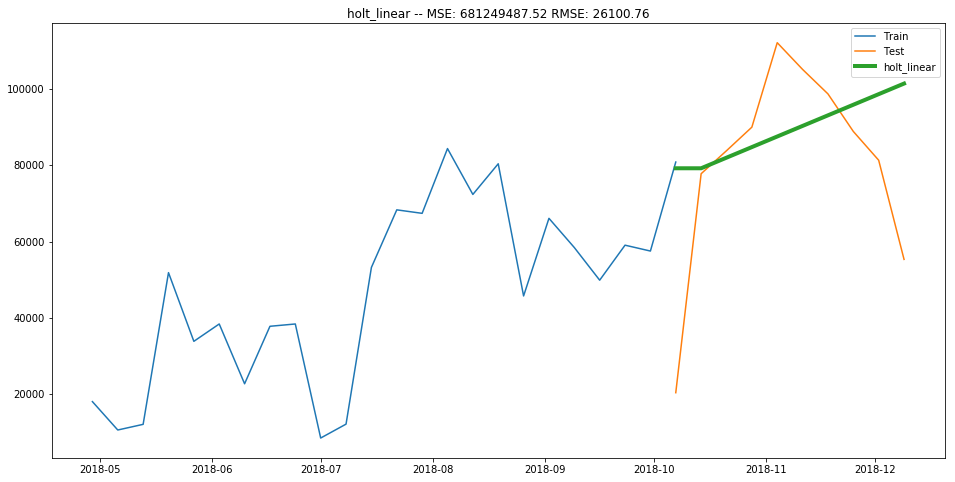

In [128]:
plot_and_eval(y_hat.holt_linear)